In [1]:
import arc
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats

## Get ARC Parameters

In [2]:
# Variables
# SF numpy files path
SF_np_path ="/home/ucfaya1@ad.ucl.ac.uk/Downloads/2022-UCL-model_output_maize"

# Actual yield csv data path 
Actual_yield_csv = '/home/ucfaya1@ad.ucl.ac.uk/Desktop/HI_Data_yara_new_backup_v1/code_data/save_code_data/AVR_geometry2022.csv'

# Output files paths 
# Name the CSV file to be saved
csv_output_file_name = 'IW_ARC_maize_2022.csv'
csv_output_file_path = "/home/ucfaya1@ad.ucl.ac.uk/Desktop/code_data/save_code_data/" + csv_output_file_name

In [3]:
df_actual_yield = pd.read_csv(Actual_yield_csv)
df_actual_yield.columns

Index(['FieldName', 'HarvestDate', 'Variety', 'AmountHectareDone', 'HaDone%',
       'Wet_Actual_Yield_tonsfield', 'AverageTonsHa', 'Average_kgha',
       'Wet_Actual_Yield_kgfield', 'DM', 'dry_actual_average_kgha',
       'dry_actual_kgfield', 'geometry', 'SoilType'],
      dtype='object')

In [4]:
# Initialize an empty list to store tuples of (folder name, ARC parameters)
median_parameters = []

# Loop to pass by all the folders created for each field searching for the SF file
for root, dirs, files in os.walk(SF_np_path):
    # Check if the file "SF_field.npz" exists in the current directory
    if "SF_field.npz" in files:
        # Get the full file path for the .npz file
        file_path = os.path.join(root, "SF_field.npz")

        # Load the .npz file and store its contents in a variable
        data = np.load(file_path)

        # Access the numpy array 'dat' (storage of scaling factors)
        if 'dat' in data:
            dat_array = data['dat']

            # Calculate the median of all the pixels in the field of all the parameters
            median_values = np.median(dat_array, axis=0)

            # Get the name of the subdirectory folder and remove "_geometry"
            FieldName = os.path.basename(root).replace("_geometry", "")

            median_parameters.append((FieldName, median_values[0], median_values[1],
                                      median_values[2], median_values[3], median_values[4],
                                      median_values[5], median_values[6], median_values[7],
                                      median_values[8], median_values[9], median_values[10],
                                      median_values[11], median_values[12], median_values[13],
                                      median_values[14]))

        data.close()

# Convert list of tuples to a DataFrame
df_parameters = pd.DataFrame(median_parameters, columns=['FieldName', 'N','Cab','Cm','Cw','LAI','Ala',
                                                         'Cbrown','m0','n0','m1','n1','B','S1','S2','SMp'])

print("DataFrame with median parameters values:")
print(df_parameters)

DataFrame with median parameters values:
                                 FieldName         N       Cab        Cm  \
0      staf de schutter achter stal rechts  1.128377  0.630670  0.436564   
1                         piet tops rechts  1.046370  0.693188  0.598338   
2                  roger bloks trekkertrek  1.152919  0.660048  0.458550   
3                       peerke snip buspad  1.154147  0.642420  0.561524   
4                     johan wens beverdonk  1.158623  0.640292  0.515112   
..                                     ...       ...       ...       ...   
188                             marc kozen  1.085340  0.715448  0.507530   
189            war gijs  avoortstraat voor  0.988395  0.693350  0.569938   
190  emma van den dungen goorstraat achter  1.158022  0.634241  0.421548   
191                     harm fabri jokeven  1.109990  0.679484  0.411619   
192       kees verhagen rauwenbocht in bos  1.156289  0.586032  0.429697   

           Cw       LAI       Ala    Cbrown   

In [5]:
# Check for incomplete values 
nan_values = df_parameters.isna().sum()
print(nan_values)
df_parameters.columns

FieldName    0
N            0
Cab          0
Cm           0
Cw           0
LAI          0
Ala          0
Cbrown       0
m0           0
n0           0
m1           0
n1           0
B            0
S1           0
S2           0
SMp          0
dtype: int64


Index(['FieldName', 'N', 'Cab', 'Cm', 'Cw', 'LAI', 'Ala', 'Cbrown', 'm0', 'n0',
       'm1', 'n1', 'B', 'S1', 'S2', 'SMp'],
      dtype='object')

In [6]:
# Merge the dataframes based on the 'Name' column
df_merged = df_actual_yield.merge(df_parameters[['FieldName','N', 'Cab', 'Cm', 'Cw', 'LAI', 'Ala', 'Cbrown', 'm0', 'n0', 'm1', 'n1','B','S1','S2','SMp']], on='FieldName', how='left')

In [7]:
df_merged.columns

Index(['FieldName', 'HarvestDate', 'Variety', 'AmountHectareDone', 'HaDone%',
       'Wet_Actual_Yield_tonsfield', 'AverageTonsHa', 'Average_kgha',
       'Wet_Actual_Yield_kgfield', 'DM', 'dry_actual_average_kgha',
       'dry_actual_kgfield', 'geometry', 'SoilType', 'N', 'Cab', 'Cm', 'Cw',
       'LAI', 'Ala', 'Cbrown', 'm0', 'n0', 'm1', 'n1', 'B', 'S1', 'S2', 'SMp'],
      dtype='object')

In [8]:
nan_values = df_merged.isna().sum()

# Print the count of NaN values for each column
print(nan_values)

# Create a set to store unique FieldName values with NaN
fieldnames_with_nan = set()

# Loop through columns and collect FieldName for NaN values
for column, count in nan_values.items():
    if count > 0:
        fieldnames_with_nan.update(df_merged.loc[df_merged[column].isna(), 'FieldName'].unique())

# Print the list of FieldName values with NaN
print("FieldNames with NaN values:")
for fieldname in fieldnames_with_nan:
    print(fieldname)
df_merged = df_merged.dropna()

# Save as csv
df_merged.to_csv(csv_output_file_path, index=False)

FieldName                     0
HarvestDate                   0
Variety                       0
AmountHectareDone             0
HaDone%                       0
Wet_Actual_Yield_tonsfield    0
AverageTonsHa                 0
Average_kgha                  0
Wet_Actual_Yield_kgfield      0
DM                            0
dry_actual_average_kgha       0
dry_actual_kgfield            0
geometry                      0
SoilType                      0
N                             0
Cab                           0
Cm                            0
Cw                            0
LAI                           0
Ala                           0
Cbrown                        0
m0                            0
n0                            0
m1                            0
n1                            0
B                             0
S1                            0
S2                            0
SMp                           0
dtype: int64
FieldNames with NaN values:


## ARC & average yield kg/ha Analysis

R-squared (R2) Score: 0.41253106543925455


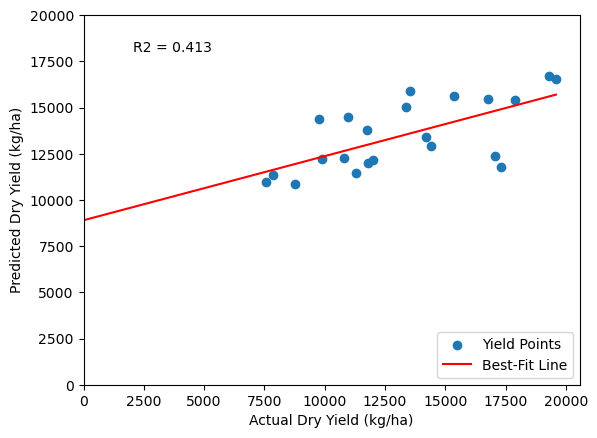

In [9]:
# Biophysical VS Avg yield 
X = df_merged[['N', 'Cab', 'Cm', 'Cw', 'LAI', 'Ala', 'Cbrown']] # Predicted dataset
y = df_merged['dry_actual_average_kgha']       # Actual dataset

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Test the model on the testing data
y_pred = model.predict(X_test)

# Assuming you have 'y_test' as the actual yield test data and 'y_pred' as the modeled predicted values
r2 = r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)

# Scatter plot with R2 score
plt.scatter(y_test, y_pred, label='Yield Points')
plt.xlabel('Actual Dry Yield (kg/ha)')
plt.ylabel('Predicted Dry Yield (kg/ha)')
plt.text(0.1, 0.9, f'R2 = {r2:.3f}', transform=plt.gca().transAxes)

# Calculate the coefficients of the best-fit line using np.polyfit
a, b = np.polyfit(y_test, y_pred, 1)
# Plot the best-fit line
x_range = np.linspace(0, max(y_test), 100)
plt.plot(x_range, a * x_range + b, color='red', label='Best-Fit Line')
plt.legend(loc='lower right')
plt.xlim(0)
plt.ylim(0,20000)

# Save the plot as an image file
plt.savefig('/home/ucfaya1@ad.ucl.ac.uk/Desktop/plots/ARCmaize_BP_avg_2022.png', dpi=400)
plt.show()

R-squared (R2) Score: 0.5692095044313026


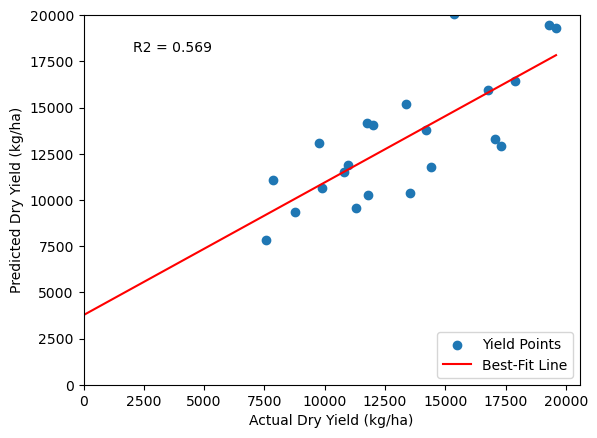

In [10]:
# biophysical + phenology VS avg yield kh/ha
X = df_merged[['N', 'Cab', 'Cm', 'Cw', 'LAI', 'Ala', 'Cbrown', 'm0', 'n0', 'm1', 'n1']] # Predicted dataset
y = df_merged['dry_actual_average_kgha']       # Actual dataset

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Test the model on the testing data
y_pred = model.predict(X_test)

# Assuming you have 'y_test' as the actual yield test data and 'y_pred' as the modeled predicted values
r2= r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)

# Scatter plot with R2 score
plt.scatter(y_test, y_pred, label='Yield Points')
plt.xlabel('Actual Dry Yield (kg/ha)')
plt.ylabel('Predicted Dry Yield (kg/ha)')
plt.text(0.1, 0.9, f'R2 = {r2:.3f}', transform=plt.gca().transAxes)

# Calculate the coefficients of the best-fit line using np.polyfit
a, b = np.polyfit(y_test, y_pred, 1)
# Plot the best-fit line
x_range = np.linspace(0, max(y_test), 100)
plt.plot(x_range, a * x_range + b, color='red', label='Best-Fit Line')
plt.legend(loc='lower right')
plt.xlim(0)
plt.ylim(0,20000)

plt.savefig('/home/ucfaya1@ad.ucl.ac.uk/Desktop/plots/ARCmaize_BP_Phen_avg_2022.png', dpi=400)
plt.show()

R-squared (R2) Score: 0.4313688647802475


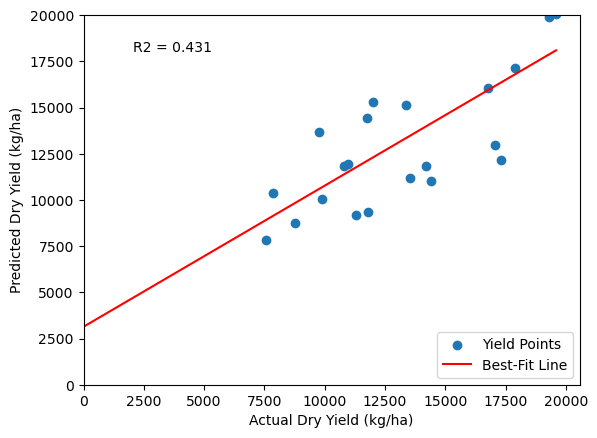

In [11]:
# 15 parameters VS avg yield kg/ha
X = df_merged[['N', 'Cab', 'Cm', 'Cw', 'LAI', 'Ala', 'Cbrown', 'm0', 'n0', 'm1', 'n1','B','S1','S2','SMp']] # Predicted dataset
y = df_merged['dry_actual_average_kgha']       # Actual dataset

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Test the model on the testing data
y_pred = model.predict(X_test)

# Assuming you have 'y_test' as the actual yield test data and 'y_pred' as the modeled predicted values
r2= r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)

# Scatter plot with R2 score
plt.scatter(y_test, y_pred, label='Yield Points')
plt.xlabel('Actual Dry Yield (kg/ha)')
plt.ylabel('Predicted Dry Yield (kg/ha)')
plt.text(0.1, 0.9, f'R2 = {r2:.3f}', transform=plt.gca().transAxes)

# Calculate the coefficients of the best-fit line using np.polyfit
a, b = np.polyfit(y_test, y_pred, 1)
# Plot the best-fit line
x_range = np.linspace(0, max(y_test), 100)
plt.plot(x_range, a * x_range + b, color='red', label='Best-Fit Line')
plt.legend(loc='lower right')
plt.xlim(0)
plt.ylim(0,20000)

plt.savefig('/home/ucfaya1@ad.ucl.ac.uk/Desktop/plots/ARCmaize_15_avg_2022.png', dpi=400)
plt.show()

## ARC & Total yield kg/field Analysis

R-squared (R2) Score: 0.3315525292606335


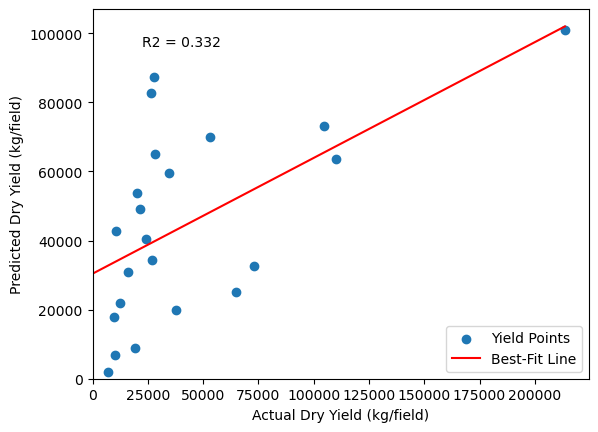

In [12]:
# Biophysical + phenology VS total yield
X = df_merged[['N', 'Cab', 'Cm', 'Cw', 'LAI', 'Ala', 'Cbrown', 'm0', 'n0', 'm1', 'n1']] # Predicted dataset
y = df_merged['dry_actual_kgfield']       # Actual dataset

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Test the model on the testing data
y_pred = model.predict(X_test)

# Assuming you have 'y_test' as the actual yield test data and 'y_pred' as the modeled predicted values
r2= r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)

# Scatter plot with R2 score
plt.scatter(y_test, y_pred, label='Yield Points')
plt.xlabel('Actual Dry Yield (kg/field)')
plt.ylabel('Predicted Dry Yield (kg/field)')
plt.text(0.1, 0.9, f'R2 = {r2:.3f}', transform=plt.gca().transAxes)

# Calculate the coefficients of the best-fit line using np.polyfit
a, b = np.polyfit(y_test, y_pred, 1)
# Plot the best-fit line
x_range = np.linspace(0, max(y_test), 100)
plt.plot(x_range, a * x_range + b, color='red', label='Best-Fit Line')
plt.legend(loc='lower right')
plt.xlim(0)
plt.ylim(0)

# Save the plot as an image file
plt.savefig('/home/ucfaya1@ad.ucl.ac.uk/Desktop/plots/ARCmaize_BP_Phen_tot_2022.png', dpi=400)
plt.show()

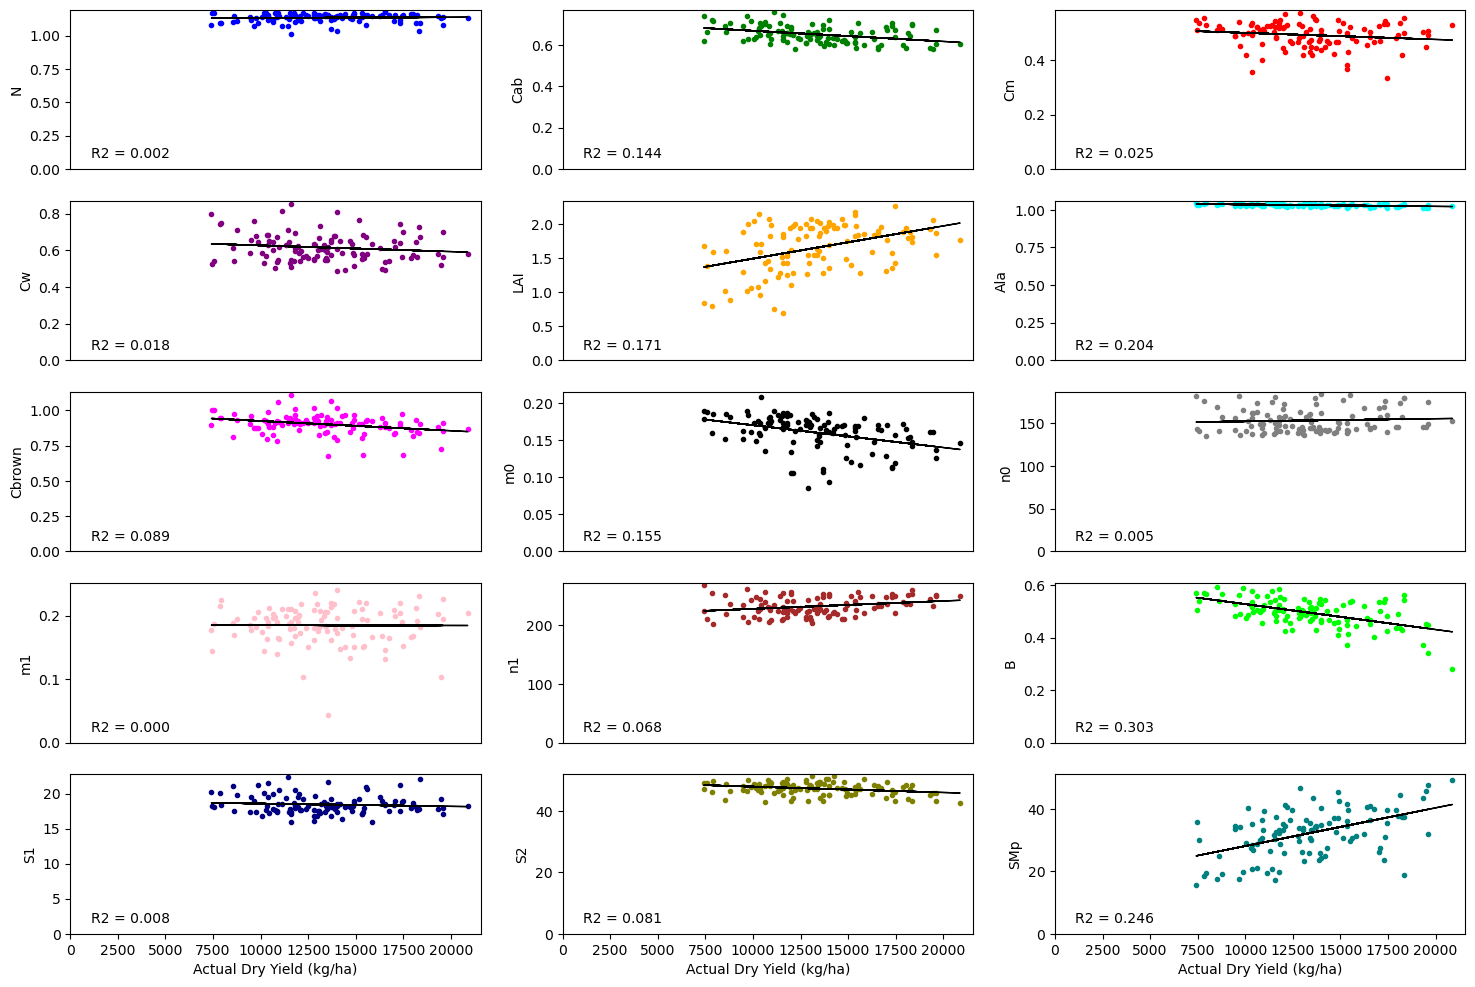

In [13]:
variable_colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'black', 'gray', 'pink', 'brown', 'lime', 'navy', 'olive', 'teal']

# List of parameters
parameters = ['N', 'Cab', 'Cm', 'Cw', 'LAI', 'Ala', 'Cbrown', 'm0', 'n0', 'm1', 'n1', 'B', 'S1', 'S2', 'SMp']

num_rows = 5
num_cols = 3
num_plots = len(parameters)
num_figures = (num_plots + (num_rows * num_cols) - 1) // (num_rows * num_cols)

# Loop to create separate figures
for figure_num in range(num_figures):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 12))
    
    # Loop to populate subplots within the current figure
    for i, parameter in enumerate(parameters[figure_num * num_rows * num_cols : (figure_num + 1) * num_rows * num_cols]):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        
        x_axis = df_merged['dry_actual_average_kgha']
        y_axis = df_merged[parameter]
        color = variable_colors[i]
        
        # Create a LinearRegression model
        model = LinearRegression()
        
        # Fit the model
        model.fit(x_axis.values.reshape(-1, 1), y_axis)
        
        # Predict using the model
        y_pred = model.predict(x_axis.values.reshape(-1, 1))
        
        # Calculate R-squared
        r2 = r2_score(y_axis, y_pred)
        
        # Plot the data and regression line
        ax.plot(x_axis, y_axis, 'o', color=color, markersize=3)
        ax.plot(x_axis, y_pred, color='black', linewidth=1)
        ax.set_xlim(0)
        ax.set_ylim(0)
        ax.set_ylabel(parameter)
        
        # Display R-squared value at the bottom left corner
        ax.text(0.05, 0.05, f'R2 = {r2:.3f}', transform=ax.transAxes, ha='left', va='bottom')
        
        if row < num_rows - 1:
            ax.set_xticks([])
            ax.set_xlabel('')
        
        if row == num_rows - 1:
            ax.set_xlabel('Actual Dry Yield (kg/ha)')
    
    # Save the figure as an image file
    plt.savefig('/home/ucfaya1@ad.ucl.ac.uk/Desktop/plots/ARCmaize_15all_avg_2022.png', dpi = 400)
    plt.show()

R-squared (R2) Score: 0.737045862599524


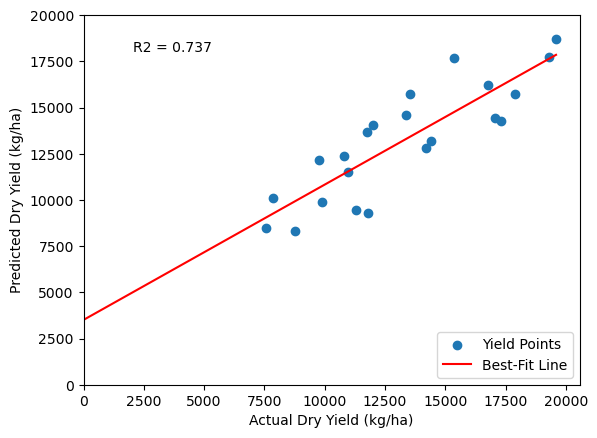

In [14]:
# Best fit combination 
X = df_merged[['Cab', 'Cm', 'LAI', 'Ala', 'Cbrown', 'm0', 'n1','B','S2','SMp']] # Predicted dataset
y = df_merged['dry_actual_average_kgha']       # Actual dataset

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Test the model on the testing data
y_pred = model.predict(X_test)

# Assuming you have 'y_test' as the actual yield test data and 'y_pred' as the modeled predicted values
r2= r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)

# Scatter plot with R2 score
plt.scatter(y_test, y_pred, label='Yield Points')
plt.xlabel('Actual Dry Yield (kg/ha)')
plt.ylabel('Predicted Dry Yield (kg/ha)')
plt.text(0.1, 0.9, f'R2 = {r2:.3f}', transform=plt.gca().transAxes)

# Calculate the coefficients of the best-fit line using np.polyfit
a, b = np.polyfit(y_test, y_pred, 1)
# Plot the best-fit line
x_range = np.linspace(0, max(y_test), 100)
plt.plot(x_range, a * x_range + b, color='red', label='Best-Fit Line')
plt.legend(loc='lower right')
plt.xlim(0)
plt.ylim(0,20000)

plt.savefig('/home/ucfaya1@ad.ucl.ac.uk/Desktop/plots/bestfit_combination_2022.png', dpi=400)
plt.show()

R-squared (R2) Score: 0.6584824228776192


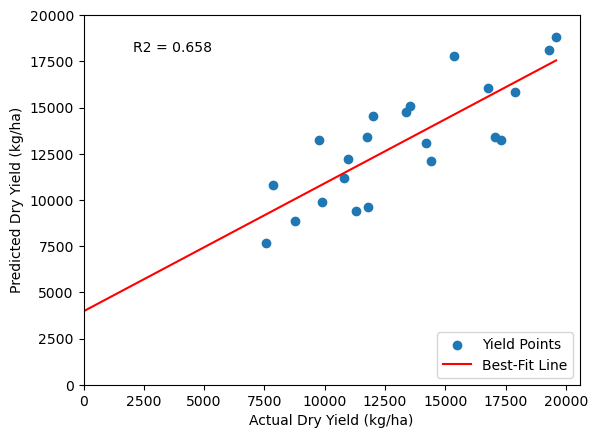

In [15]:
# same combination as 2021
X = df_merged[['N', 'Cab', 'Cm', 'Cw', 'LAI', 'Ala', 'Cbrown', 'm0', 'n1','S2','B','SMp']] # Predicted dataset
y = df_merged['dry_actual_average_kgha']       # Actual dataset

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Test the model on the testing data
y_pred = model.predict(X_test)

# Assuming you have 'y_test' as the actual yield test data and 'y_pred' as the modeled predicted values
r2= r2_score(y_test, y_pred)

print("R-squared (R2) Score:", r2)

# Scatter plot with R2 score
plt.scatter(y_test, y_pred, label='Yield Points')
plt.xlabel('Actual Dry Yield (kg/ha)')
plt.ylabel('Predicted Dry Yield (kg/ha)')
plt.text(0.1, 0.9, f'R2 = {r2:.3f}', transform=plt.gca().transAxes)

# Calculate the coefficients of the best-fit line using np.polyfit
a, b = np.polyfit(y_test, y_pred, 1)
# Plot the best-fit line
x_range = np.linspace(0, max(y_test), 100)
plt.plot(x_range, a * x_range + b, color='red', label='Best-Fit Line')
plt.legend(loc='lower right')
plt.xlim(0)
plt.ylim(0,20000)

plt.savefig('/home/ucfaya1@ad.ucl.ac.uk/Desktop/plots/cleaned_like2021_2022.png', dpi=400)
plt.show()